## Notebook that takes dihadron ntuples and plots kinematics distributions also with MC

In [18]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time

import seaborn as sns

import root_pandas as rpd
from root_pandas import read_root

#mpl.rcParams['figure.figsize'] = 6.2,3.5
#mpl.rcParams['axes.labelsize'] = 17
#mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['lines.markersize'] = 6
#mpl.rcParams['legend.fontsize']= 13

## Get data

In [19]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

In [20]:
df = {}
df_trigger = {}

for target in ['Pb']:
    print 'Getting dataframes from target %s'%target
    df[target]=getdatainChunks('Pairs_%s.root'%target, target)
    df['%s_mix'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_mix'%target)
    df['D_%s'%target]= getdatainChunks('Pairs_%s.root'%target, 'D_%s'%target)
    df['D_%s_mix'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_mix'%target)
    print 'Get trigger dataframes from target%s'%target
    df_trigger['%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_trigger'%target)
    


Getting dataframes from target Pb
110447
641296
574977
2910316
Get trigger dataframes from targetPb
527766
2349115


In [ ]:
df['D'] = pd.concat([df['D_Pb'],df['D_Fe'],df['D_C']]) #simply combine the deuterium results for all targets
df['D_mix'] = pd.concat([df['D_Pb_mix'],df['D_Fe_mix'],df['D_C_mix']]) #simply combine the deuterium results for all targets
df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_C_trigger']]) #simply combine the deuterium results for all targets



In [21]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    dataframe = applyCut(dataframe, 'W>2.0', 'W>2.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.5', 'Nu>3.5 :')

    dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyCutsPair(fullDataframe,name='default'):
    print 'Starting election on dipion variables'
    dataframe = fullDataframe
    dataframe.eval('z_tot = z+z_asso', inplace=True)
    dataframe.eval('E_asso = z_asso*Nu', inplace=True)
    dataframe.eval('P_asso = sqrt(E_asso*E_asso-0.140*0.140)', inplace=True)
    #dataframe = applyCut(dataframe, 'z+z_asso<0.8', 'z+z_asso<0.8')
    return dataframe

def printPairBreakdown(dataframe):
    
    print 'Pairs with Leading pi+', dataframe.query('pid==211').shape[0]
    print 'Pairs with Leading pi-', dataframe.query('pid==-211').shape[0]
    print 'Pairs with Sub-Leading pi+', dataframe.query('pid_asso==211').shape[0]
    print 'Pairs with Sub-Leading pi-', dataframe.query('pid_asso==-211').shape[0]
    print 'pi+ pi+ pairs',dataframe.query('pid==211 and pid_asso==211').shape[0]
    print 'pi- pi- pairs',dataframe.query('pid==-211 and pid_asso==-211').shape[0]
    print 'pi+ pi- pairs',dataframe.query('pid==211 and pid_asso==-211').shape[0]
    print 'pi- pi+ pairs',dataframe.query('pid==-211 and pid_asso==211').shape[0]
    print '//////////////////////////////////////////////////////'
    return 



def printMeans(dataframe):   
    for variable in ['Q2','Xb','Nu','z','z_asso','P','P_asso']:
        print variable
        print 'Average ' + variable , np.mean(dataframe[variable]) , ' min--max ' , np.min(dataframe[variable]), np.max(dataframe[variable])
        print dataframe[variable].quantile([0.25,0.5,0.75])
  

    
    #print 'Pairs with Leading pi-', dataframe['pid'].count(-211)
    #print 'Pairs with Sub-Leading pi+', dataframe['pid_asso'].count(211)
    #print 'Pairs with Sub-Leading pi-', dataframe['pid_asso'].count(-211)

In [ ]:
#apply cuts

In [22]:
for key in df.keys():
    print key
    df[key] = applyCuts(df[key])
    #printPairBreakdown(df[key])
    df[key] = applyCutsPair(df[key])
    print '--------------'
    
for key in df_trigger.keys():
    print key
    df_trigger[key] = applyCuts(df_trigger[key])

Pb
Entries before cut  110447
Q2>1.0 : 110447  (100.00  %)
W>2.0 : 110447  (100.00  %)
z>0.5 : 48356  (43.78  %)
P<2.5  41888  (86.62  %)
inelasticity < 0.85 40587  (96.89  %)
Starting election on dipion variables
--------------
D_Pb
Entries before cut  574977
Q2>1.0 : 574977  (100.00  %)
W>2.0 : 574976  (100.00  %)
z>0.5 : 273045  (47.49  %)
P<2.5  237372  (86.94  %)
inelasticity < 0.85 231672  (97.60  %)
Starting election on dipion variables
--------------
D_Pb_mix
Entries before cut  2910316
Q2>1.0 : 2910316  (100.00  %)
W>2.0 : 2910259  (100.00  %)
z>0.5 : 1696855  (58.31  %)
P<2.5  1371246  (80.81  %)
inelasticity < 0.85 1345961  (98.16  %)
Starting election on dipion variables
--------------
Pb_mix
Entries before cut  641296
Q2>1.0 : 641296  (100.00  %)
W>2.0 : 641228  (99.99  %)
z>0.5 : 353897  (55.19  %)
P<2.5  290443  (82.07  %)
inelasticity < 0.85 283752  (97.70  %)
Starting election on dipion variables
--------------
D_Pb_trigger
Entries before cut  2349115
Q2>1.0 : 2349115 

## Event Variables

In [ ]:
def plotEventVariables(df):
    fig = plt.figure( figsize=(20, 10))
    plt.subplot(2,3,1)
    plt.hist(df['Nu'], bins=25,range =(2,5), histtype='step', normed=True,label='Data')
    plt.legend()
    plt.xlabel("Nu [GeV]", fontsize=20)

    plt.subplot(2,3,2)
    plt.hist(df['Q2'], bins=25,range =(1,5), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['Q2'], bins=25,range = (1,5),  normed = True,alpha=0.2,label='MC')
    plt.xlabel("$Q^{2} [GeV^{2}]$", fontsize=20)

    #plt.subplot(2,3,3)
    #plt.hist(df['W'], bins=25,range =(1,3), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['W'], bins=25,range = (1,3), normed = True,alpha=0.2,label='MC')
    #plt.xlabel("$W$ [GeV]", fontsize=20)

    plt.subplot(2,3,4)
    plt.hist(df['Xb'], bins=25,range =(0,1), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['Xb'], bins=25,range = (0,1),  normed = True,alpha=0.2,label='MC')
    plt.xlabel("$x$", fontsize=20)
    
    plt.subplot(2,3,5)
    plt.hist(df['inelasticity'], bins=25,range =(0,1), histtype='step', normed=True,label='Data')
    plt.legend()
    plt.xlabel("inelasticity", fontsize=20)
    plt.axvline(x=.850,color='red',linestyle='--')


    #plt.subplot(2,3,5)
    #plt.hist(df['SectorEl'], bins = 12, range = (-0.5,5.5),histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['SectorEl'], bins = 12, range=(-0.5,5.5), normed = True,alpha=0.2,label='MC')
    #plt.xlabel('Sector El')

    #plt.subplot(2,3,6)
    #plt.hist(df['deltaZ'], bins = 100, range=(-50,50), histtype='step', normed=True,label='Data')
    #plt.hist(MC_reco['deltaZ'], bins = 100, range=(-50,50), normed = True,alpha=0.2,label='MC')
    #plt.xlabel('Delta z')
    #plt.show()
    
    return

## Hadron Variables

In [ ]:
def plotHadronVariables(df):
    fig = plt.figure( figsize=(16, 16))
    plt.subplot(3,4,1)
    plt.hist(df['xf'], bins=25,range=(-1,1), histtype='step', normed=True,label='xf_1')
    plt.hist(df['xf_asso'], bins=25,range=(-1,1), histtype='step', normed=True,label='xf_2')
    plt.legend(loc='best', frameon=False)
    plt.xlabel("$X_{\mathrm{f}}$", fontsize=14)

    plt.subplot(3,4,2)
    plt.hist(df['z'], bins=25,range =(0,1), histtype='step', normed=True,label='z1')
    plt.hist(df['z_asso'], bins=25,range =(0,1), histtype='step', normed=True,label='z2')
    plt.hist(df['z_tot'], bins=25,range =(0,1), histtype='step', normed=True,label='z1+z2')
    plt.legend()
    plt.xlabel("$z_{\mathrm{h}}$", fontsize=14)
    
    plt.subplot(3,4,3)
    plt.hist(df['y'], range=(-2.5,2.5), bins = 50,histtype='step', normed=True,label='y1')
    plt.hist(df['y_asso'], range=(-2.5,2.5), bins = 50,histtype='step', normed=True,label='y2')
    plt.xlabel("rapidity", fontsize=14)
    plt.legend()
    
    plt.subplot(3,4,4)
    plt.hist(df['phi_pq'], bins=25, histtype='step', normed=True,label='phi1')
    plt.hist(df['phi_pq_asso'], bins=25, histtype='step', normed=True,label='phi2')
    plt.xlabel("$\phi_{pq}$ [\circ]", fontsize=14)
    plt.legend()
    
    plt.subplot(3,4,5)
    plt.hist(df['mass'], bins=50, histtype='step', range=(0,2.0),normed=True)
    plt.axvline(x=0.770,linestyle='--',color='black',alpha=0.4)

    plt.xlabel("mass [GeV]", fontsize=14)

    plt.subplot(3,4,6)
    plt.hist(df['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True)
    plt.axvline(x=0.938,linestyle='--',color='black',alpha=0.4)
    plt.xlabel("missing mass [GeV]", fontsize=14)
    
    plt.subplot(3,4,7)
    plt.hist(df['dy'], bins=50, histtype='step', range=(-3.5,3.5),normed=True)
    plt.xlabel("delta-rapidity", fontsize=14)
    
    
    plt.subplot(3,4,8)
    plt.hist(df['dphi'], bins=20, histtype='step',normed=True)
    plt.xlabel("dphi", fontsize=14)
    
    
    plt.subplot(3,4,9)
    plt.hist(df['dipion_pt'], bins=50, histtype='step',range=(0.0,5.0),normed=True, label='dipion pt')
    plt.hist(df['t'], bins=50, histtype='step',range=(0.0,5.0),normed=True,label='t')
    plt.legend()
    plt.xlabel("dipion_pt", fontsize=14)

    plt.subplot(3,4,10)
    plt.hist(df['P'], bins=50,range =(0,3.0), histtype='step', normed=True,label='P1')
    plt.hist(df['P_asso'], bins=50,range =(0,3.0), histtype='step', normed=True,label='P2')
    plt.xlabel("$P$ GeV" , fontsize=14)
    plt.legend()
    
    plt.subplot(3,4,11)
    plt.hist(df['E'], bins=50,range =(0,3.0), histtype='step', normed=True,label='E1')
    plt.hist(df['E_asso'], bins=50,range =(0,3.0), histtype='step', normed=True,label='E2')
    plt.xlabel("$E$ GeV", fontsize=14)
    plt.legend()

    plt.subplot(3,4,12)
    plt.hist(df['phi_lab'], bins=50, histtype='step', normed=True,label='phi1')
    plt.xlabel("$\phi_{lab}$ [\circ]", fontsize=14)
    plt.legend()


    plt.show()
    return 

## Profile distributions to see correlation with kinematic variables with z2

#### This is accomplished with sns.regplot (seaborn package needed). It plots the average of a quantity in bins o the other quantities. This is more useful than a 2D distribution

In [ ]:
fig = plt.figure( figsize=(14, 3))

for ivar,variable in enumerate(['Q2','Xb','Nu','W']):
    plt.subplot(1,4,ivar+1)                                       
    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_1.png')
plt.clf()
          
    
for ivar,variable in enumerate(['z','P','P_asso']): 
    plt.subplot(1,4,ivar+1)                   
    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_2.png')                               
plt.clf()
                               
for ivar,variable in enumerate(['xf','xf_asso','y','y_asso','dy']):  
    plt.subplot(1,5,ivar+1)                   

    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_3.png')     
plt.clf() 
                               
for ivar,variable in enumerate(['mass','missing_mass','dipion_pt','dphi']): 
    plt.subplot(1,4,ivar+1)                   
    for i, target in enumerate(['D','C','Fe','Pb']):
        sns.regplot(x=df[target]['z_asso'],y=df[target][variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),12),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.tight_layout()
plt.savefig('ProfilePlots_4.png')    
                               
                             

## plot for mixed events. In this case, key correlation should go away


## Profile plots but only for z1+z2<0.8

In [ ]:
fig = plt.figure( figsize=(21, 21))

for ivar,variable in enumerate(['Q2','Nu','Xb','W','z','P','P_asso','mass','missing_mass','dy','dipion_pt','xf','xf_asso','y','y_asso','phi_pq']):
    plt.subplot(4,4,ivar+1)
    for i, target in enumerate(['Pb','D']):
        sns.regplot(x=df[target].query('z_tot<0.8')['z_asso'],y=df[target].query('z_tot<0.8')[variable],x_bins=np.logspace(np.log10(0.05), np.log10(0.5),9),fit_reg=None,label=target)
    plt.legend(loc='best',frameon=False)

plt.xlim([0.0,0.5])
plt.savefig('ProfilePlots_withztotcut.png')

In [ ]:
plotEventVariables(df['Pb'])


In [ ]:
plotHadronVariables(df['D_Pb'])

In [ ]:
plotHadronVariables(df['Pb_mix'])

## invariant mass distribution

In [ ]:
fig, axs = plt.subplots(3, 4,sharex=True, sharey=True,figsize=(14,9), gridspec_kw={'wspace':0})

for i, target in enumerate(['D','C','Fe','Pb']):
    axs[0,i].hist(df[target]['mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='%s'%target,linewidth=2.0)
    axs[0,i].hist(df['%s_mix'%target]['mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[0,i].axvline(x=0.770,linestyle='--',color='black',alpha=0.6)
    axs[0,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[0,i].legend(loc='best',frameon=False)

axs[0,0].yaxis.set_label_text("entries (normalized)", fontsize=13)


for i, target in enumerate(['D','C','Fe','Pb']):
    axs[1,i].hist(df[target].query('z_tot<0.8')['mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='%s'%target,linewidth=2.0)
    axs[1,i].hist(df['%s_mix'%target].query('z_tot<0.8')['mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[1,i].axvline(x=0.770,linestyle='--',color='black',alpha=0.6)
    axs[1,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[1,i].legend(loc='best',frameon=False)

for i, target in enumerate(['D','C','Fe','Pb']):
    axs[2,i].hist(df[target].query('z_tot>0.8')['mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='%s'%target,linewidth=2.0)
    axs[2,i].hist(df['%s_mix'%target].query('z_tot>0.8')['mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[2,i].axvline(x=0.770,linestyle='--',color='black',alpha=0.6)
    axs[2,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[2,i].legend(loc='best',frameon=False)

plt.tight_layout()
plt.savefig('Massforztotbins.png')    
                               

## Missing mas distribution

In [ ]:
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(14,4), gridspec_kw={'wspace':0})

for i, target in enumerate(['D','C','Fe','Pb']):
    axs[i].hist(df[target]['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='all',linewidth=2.0)
    axs[i].hist(df[target].query('z_tot<0.8')['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='z1+z2<0.8',linewidth=2.0)
    axs[i].hist(df[target].query('z_tot>0.8')['missing_mass'], bins=50, histtype='step', range=(0,2.0),normed=True,label='z1+z2>0.8',linewidth=2.0)

    #axs[i].hist(df['%s_mix'%target]['missing_mass'], bins=50, range=(0,2.0),normed=True,alpha=0.4,label='%s mixed'%target)
    axs[i].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
    axs[i].xaxis.set_label_text("Missing mass  [GeV]", fontsize=13)
    axs[i].set_title(target)
    axs[i].legend(loc='best',frameon=False)

axs[0].yaxis.set_label_text("pdf", fontsize=13)


plt.tight_layout()
plt.savefig('MissingMassforztotbins.png')    

## Z and z_asso distributions without z1+z2 selection

In [ ]:
fig, axs = plt.subplots(1, 2,sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})

axs[0].hist(df['D']['z_asso'], bins=30,range =(0,0.5), normed=True,label='D',alpha=0.5)

for i, target in enumerate(['C','Fe','Pb']):
    axs[0].hist(df[target]['z_asso'], bins=30,range =(0,0.5), histtype='step', normed=True,label=[target])
    
axs[1].hist(df['D']['z'], bins=50,range =(0.5,1.0), normed=True,label='D',alpha=0.5)
for i, target in enumerate(['C','Fe','Pb']):
    axs[1].hist(df[target]['z'], bins=50,range =(0.5,1.0), histtype='step', normed=True,label=[target]) 
 

axs[0].xaxis.set_label_text("$z_{2}$", fontsize=13)
axs[1].xaxis.set_label_text("$z_{1}$", fontsize=13)
axs[0].yaxis.set_label_text("entries (normalized)", fontsize=13)

plt.legend(loc='best',frameon=False)

plt.savefig('Zdistributions_all.png')    

## Z and z_asso distributions for z1+z2<0.8

In [ ]:
fig, axs = plt.subplots(1, 2,sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})

axs[0].hist(df['D'].query('z_tot<0.8')['z_asso'], bins=30,range =(0,0.5), normed=True,label='D',alpha=0.5)

for i, target in enumerate(['C','Fe','Pb']):
    axs[0].hist(df[target].query('z_tot<0.8')['z_asso'], bins=30,range =(0,0.5), histtype='step', normed=True,label=[target])
    
axs[1].hist(df['D'].query('z_tot<0.8')['z'], bins=50,range =(0.5,1.0), normed=True,label='D',alpha=0.5)
for i, target in enumerate(['C','Fe','Pb']):
    axs[1].hist(df[target].query('z_tot<0.8')['z'], bins=50,range =(0.5,1.0), histtype='step', normed=True,label=[target]) 
 

axs[0].xaxis.set_label_text("$z_{2}$", fontsize=13)
axs[1].xaxis.set_label_text("$z_{1}$", fontsize=13)
axs[0].yaxis.set_label_text("entries (normalized)", fontsize=13)

plt.legend(loc='best',frameon=False)
plt.savefig('Zdistributions_cut.png')    

## Distributions

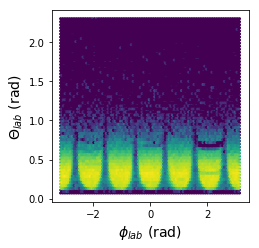

In [27]:
fig = plt.figure( figsize=(12, 12))
plt.subplot(3,3,1)
plt.hexbin(df_trigger['Pb_trigger']['phi_lab'],df_trigger['Pb_trigger']['theta_lab'],bins='log',cmap='viridis')
plt.xlabel("$\phi_{lab}$ (rad)", fontsize=14)
plt.ylabel("$\Theta_{lab}$ (rad) ", fontsize=14)


## dphi_lab vs phi_lab for same-event and mixed-events

In [77]:
def plotacceptance(df,df_mix,title='',lab=True):
    if(lab==True):
        var1 = 'phi_lab'
        var2 = 'dphi_lab'
        label = 'lab'
    else:
        var1 = 'phi_pq'
        var2 = 'dphi'
        label ='PQ'
    fig = plt.figure( figsize=(12, 9))
    plt.subplot(2,3,1)
    plt.title(title)
    plt.hexbin(df[var1],df[var2],cmap='inferno',gridsize=25)
    plt.xlabel("$\phi_{%s}$ (rad)"%label, fontsize=14)
    plt.ylabel("$d\phi_{%s}$ (rad) "%label, fontsize=14)

    plt.subplot(2,3,2)
    plt.hist(df[var1],bins=100)
    plt.xlabel("$\phi_{%s}$ (rad)"%label, fontsize=14)
    plt.title(title)

    plt.subplot(2,3,3)
    plt.hist(df[var2],bins=50)
    plt.xlabel("$d\phi_{%s}$ (rad)"%label, fontsize=14)
    plt.title(title)
    #mixed events
    plt.subplot(2,3,4)
    plt.hexbin(df_mix[var1],df_mix[var2],cmap='inferno',gridsize=25)
    plt.xlabel("$\phi_{%s}$ (rad)"%label, fontsize=14)
    plt.ylabel("$|d\phi_{%s}|$ (rad)"%label, fontsize=14) 
    #plt.title(title)

    plt.subplot(2,3,5)
    plt.hist(df_mix[var1],bins=100)
    plt.xlabel("$\phi_{%s}$ (rad)"%label, fontsize=14)
    #plt.title(title)

    plt.subplot(2,3,6)
    plt.hist(df_mix[var2],bins=50)
    plt.xlabel("$|d\phi_{%s}|$ (rad)"%label, fontsize=14)
    #plt.title(title)

    plt.show()


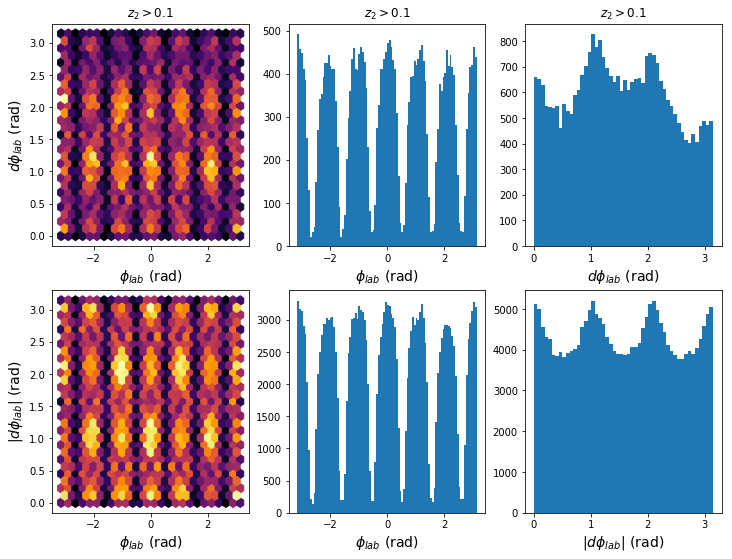

In [81]:
plotacceptance(df['Pb'].query('z_asso>0.1'),df['Pb_mix'].query('z_asso>0.1'),title='$z_2 >0.1$')

## dphi_pq vs phi_pq for same-event and mixed-events

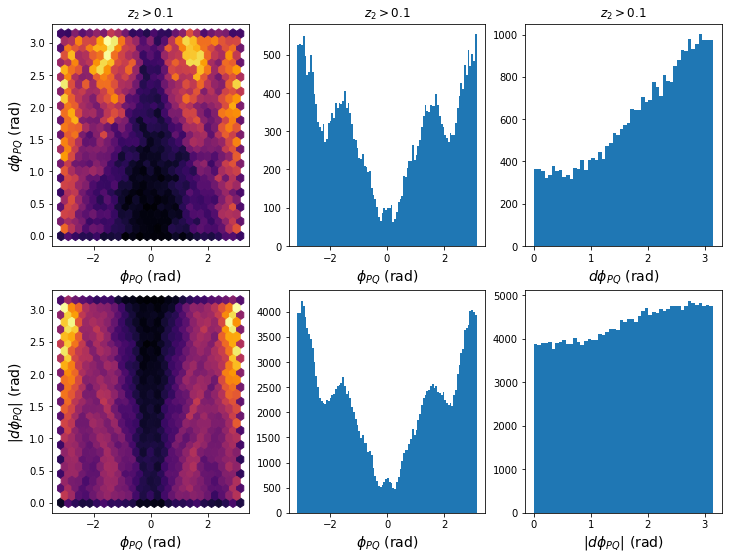

In [80]:
plotacceptance(df['Pb'].query('z_asso>0.1'),df['Pb_mix'].query('z_asso>0.1'),title='$z_2 >0.1$',lab=False)

## z vs theta (all pions)


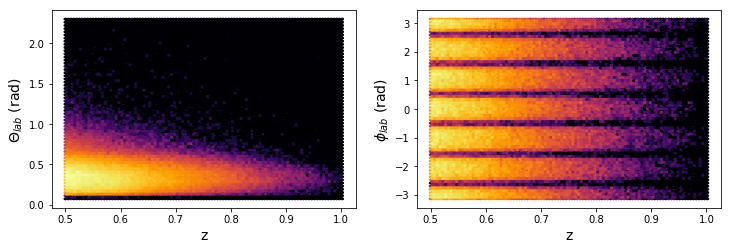

In [58]:
fig = plt.figure( figsize=(12, 8))
plt.subplot(2,2,1)
plt.hexbin(df_trigger['Pb_trigger']['z'],df_trigger['Pb_trigger']['theta_lab'], bins='log',cmap='inferno')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\Theta_{lab}$ (rad) ", fontsize=14)

plt.subplot(2,2,2)
plt.hexbin(df_trigger['Pb_trigger']['z'],df_trigger['Pb_trigger']['phi_lab'], bins='log',cmap='inferno')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\phi_{lab}$ (rad) ", fontsize=14)

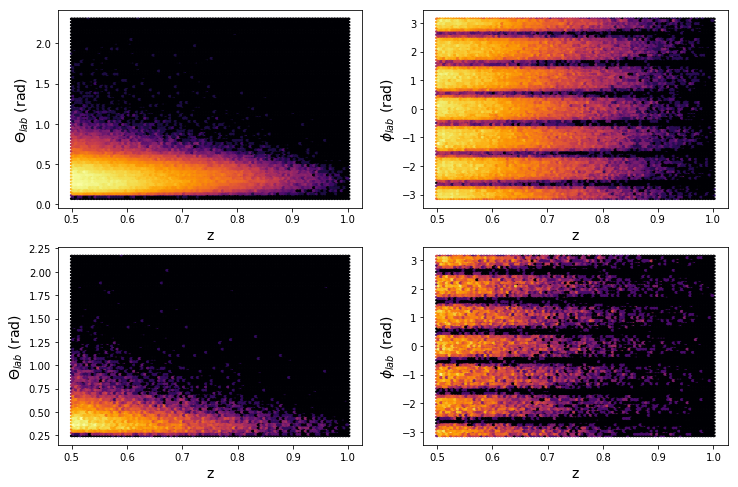

In [83]:
fig = plt.figure( figsize=(12, 8))
plt.subplot(2,2,1)
plt.hexbin(df_trigger['Pb_trigger'].query('pid>0')['z'],df_trigger['Pb_trigger'].query('pid>0')['theta_lab'], bins='log',cmap='inferno')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\Theta_{lab}$ (rad) ", fontsize=14)

plt.subplot(2,2,2)
plt.hexbin(df_trigger['Pb_trigger'].query('pid>0')['z'],df_trigger['Pb_trigger'].query('pid>0')['phi_lab'], bins='log',cmap='inferno')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\phi_{lab}$ (rad) ", fontsize=14)

plt.subplot(2,2,3)
plt.hexbin(df_trigger['Pb_trigger'].query('pid<0')['z'],df_trigger['Pb_trigger'].query('pid<0')['theta_lab'], bins='log',cmap='inferno')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\Theta_{lab}$ (rad) ", fontsize=14)

plt.subplot(2,2,4)
plt.hexbin(df_trigger['Pb_trigger'].query('pid<0')['z'],df_trigger['Pb_trigger'].query('pid<0')['phi_lab'], bins='log',cmap='inferno')
plt.xlabel("z", fontsize=14)
plt.ylabel("$\phi_{lab}$ (rad) ", fontsize=14)


In [ ]:
fig = plt.figure( figsize=(12, 12))
plt.subplot(3,3,1)
plt.hexbin(data['Pt'],data['Zh'],bins='log',cmap='viridis')
plt.xlabel("$p_{\mathrm{T}}$ [GeV]", fontsize=14)
plt.ylabel("$z_{\mathrm{h}}$ ", fontsize=14)

plt.subplot(3,3,2)
plt.hexbin(data['Q2'],data['Xb'],gridsize=50, bins='log',cmap='viridis')
plt.xlabel("$Q^{2} [GeV^{2}]$", fontsize=14)
plt.ylabel("$X_{b}$", fontsize=14)

plt.subplot(3,3,3)
plt.hexbin(data['Q2'],data['Nu'],gridsize=50,bins='log',cmap='viridis')
plt.xlabel("$Q^{2} [GeV^{2}]$", fontsize=14)
plt.ylabel("$Nu$ ", fontsize=14)

plt.subplot(3,3,4)
plt.hexbin(data.query('Zh<1.0')['PhiPQ'],data.query('Zh<1.0')['Zh'],bins='log',cmap='viridis')
plt.xlabel("$\phi_{pq}$ [\circ]", fontsize=14)
plt.ylabel("$z_{\mathrm{h}}$ ", fontsize=14)

plt.subplot(3,3,5)
plt.hexbin(data.query('Pt<1.5')['PhiPQ'],data.query('Pt<1.5')['Pt'],bins='log',cmap='viridis')
plt.xlabel("$\phi_{pq}$ [\circ]", fontsize=20)
plt.ylabel("$p_{\mathrm{T}}$ [GeV]", fontsize=20)

plt.subplot(3,3,6)
plt.hexbin(data.query('Zh<1.0 and Xf>-1.0')['Xf'],data.query('Zh<1.0 and Xf>-1.0')['Zh'],bins='log',cmap='viridis')
plt.xlabel("X_{F}", fontsize=14)
plt.ylabel("$z_{\mathrm{h}}$ ", fontsize=14)

plt.subplot(3,3,7)
plt.hexbin(data.query('Zh<1.0 and y>-4')['y'],data.query('Zh<1.0 and y>-4')['Zh'],bins='log',cmap='viridis')
plt.xlabel("Rapidity", fontsize=14)
plt.ylabel("$z_{\mathrm{h}}$ ", fontsize=14)

plt.subplot(3,3,8)
plt.hexbin(data.query('abs(Xf)<1.0 and y>-4')['y'],data.query('abs(Xf)<1.0 and y>-4')['Xf'],bins='log',cmap='viridis')
plt.xlabel("Rapidity", fontsize=14)
plt.ylabel("X_{F}", fontsize=14)


plt.show()